In [116]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import os
import ast
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

In [65]:
def parseGenres(data):
    data['genre'] = ""
    for index, row in data.iterrows():
        genres = row['genres']
        genre_list = ast.literal_eval(genres)
        if len(genre_list) == 0:
            data.at[index,'genre'] = np.nan #set empty genre lists as a NaN
        else:
            genres_temp = []
            for genre in genre_list: 
                temp = (genre['name'])
                genres_temp.append(temp)
            data.at[index,'genre'] = genres_temp
    del data['genres']
    return data

In [66]:
def parseKeywords(data):
    data['keyword'] = ""
    for index, row in data.iterrows():
        keywords = row['keywords']
        keyword_list = ast.literal_eval(keywords)
        if len(keyword_list) == 0:
            data.at[index,'keyword'] = np.nan
        else:
            keywords_temp = []
            for word in keyword_list: 
                temp = (word['name'])
                keywords_temp.append(temp)
            data.at[index,'keyword'] = keywords_temp
    del data['keywords']
    return data

In [67]:
def getStopWords():
    stopwords = []
    with open('stopwords.txt', "r") as file_in:
        for line in file_in:
            line = line.strip('\n')
            stopwords.append(line)

    stopwords_set = set(stopwords) #convert to set for faster processing
    return stopwords_set

In [71]:
def doc_to_words(raw_text):
    
    # 1. Remove non-letters        
    # Use regular expressions to do a find-and-replace
    letters_only = re.sub("[^a-zA-Z]", " ", raw_text) 
    #print(letters_only)
    
    # 2. Convert to lower case, split into individual words
    words = letters_only.lower().split()
    #print(words)
    
    # 3. In Python, searching a set is much faster than searching a list, so convert the stop words to a set.
    # Import the stopwords from text file
    stops = getStopWords()                  
    
    # 4. Remove stop words from the play
    meaningful_words = [w for w in words if not w in stops]   
    #print(meaningful_words)
    
    # 5. Join the words back into one string separated by space, and return the result.
    return( " ".join( meaningful_words ))

### Import CSVs, remove empty cells, merge and explode on genre

In [69]:
# keep titles in for sanity checks
df_meta = pd.read_csv('data/movies_metadata.csv', usecols = ['id','genres','title']) #import csv, selct columns
df_keywords = pd.read_csv('data/keywords.csv', usecols = ['id', 'keywords'])

df_meta = parseGenres(df_meta) #parse the genres into a list and save in new column, set empty genres lists to NaN
df_keywords = parseKeywords(df_keywords) #parse the keywords into a list and save in new column, set empty lists -> NaN

df_meta = df_meta.dropna(subset=['title']) #drop any rows where title is a NaN - 6 titles in total
df_meta = df_meta.dropna(subset=['genre']) #drop all rows where genres are NaNs
df_keywords = df_keywords.dropna(subset=['keyword']) #drop the 14795 rows

df_meta['id'] = df_meta['id'].astype(int) #convert strings to ints 
df_keywords['id'] = df_keywords['id'].astype(int) #convert strings to int

df = df_meta.merge(df_keywords, on='id') #merge the dat sets in 'id' column. INNER JOIN

df_all = df #store an uexploded copy

df = df.explode('genre') #explode each movie by genre, if movie has 3 genre tags then it will occur 3 times.
df = df.reset_index(drop=True) #reset index numbers

### Get uniques genres, movie counts and plot

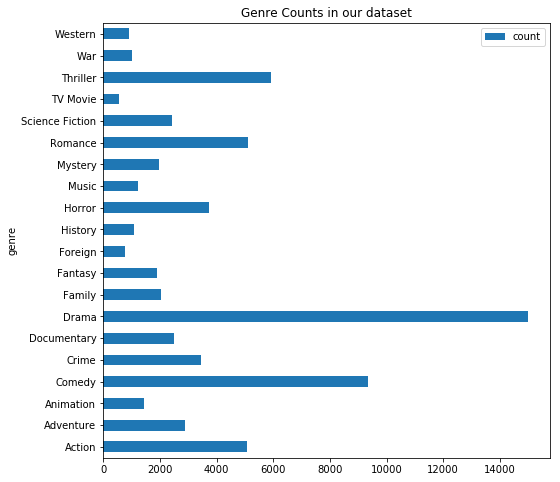

In [72]:
#find unique genres
unique_genres = df['genre'].unique() #get unique genres
unique_genres = sorted(unique_genres) # sort alphabetically

# count all the movies, these will have repeat titles due to movie having mutliple genres tags
df['count'] = 1 ##add a count column to data set, this will now eleimate any NaNs in the datase
df_genres = df.groupby(['genre']).count()['count'] #calculate counts for each genre group
df_genres = df_genres.to_frame().reset_index() # convert from series to dataframe

#plot the genres
df_plot = df_genres.set_index('genre') #set the index column to the genre names for plotting
df_plot[['count']].plot.barh(stacked = True, title = 'Genre Counts in our dataset', figsize = (8, 8));

### Create documents, clean the text and build a Corpus

In [73]:
#loop through unique genres, reading in all the keywords for each genre and save as a doc.
# we should be left with 19 unique genre documents saved as text files in a docs folder.

df_main = df.drop(columns=['id', 'title', 'count']) # remove the id and title, we dont need them anymore

### Extract keywords into Docs, clean text, store in a Corpus

In [74]:
corpus = []

for genre in unique_genres:
    doc = ""
    df_temp = df_main.loc[df_main['genre'] == genre]
    for index, row in df_temp.iterrows():
        k_words = row['keyword']
        for word in k_words:
            doc += word + " "
    clean_doc = doc_to_words(doc)
    corpus.append(clean_doc)
    

Action
Adventure
Animation
Comedy
Crime
Documentary
Drama
Family
Fantasy
Foreign
History
Horror
Music
Mystery
Romance
Science Fiction
TV Movie
Thriller
War
Western


### Vecotrize the corpus

In [152]:
vectorizer = CountVectorizer() #ceate vecotrizer object that count occurances of words
vectorizer_count = vectorizer.fit_transform(corpus).todense()  #fit the corups to the vecotr, creste a matrix

#normalize vector count by dividing by the count of movies with that genre
# This give the concetration of keywords in a genre
# takes care of the fact that some genres contain more movies than others

#matrix_normalized = np.divide(vectorizer_count, df_genres['count'].to_numpy()[:, np.newaxis]) 
#matrix = pd.DataFrame(vectorizer_count, columns=vectorizer.get_feature_names())
#matrix.index = unique_genres
#matrix

### Vectorize Query and Rank keyword relevance to Genre

In [151]:
movieId = 100

query_title = df_all.iloc[movieId]['title']
query_kwords = df_all.iloc[movieId]['keyword']
query_genres = df_all.iloc[movieId]['genre']

query = ""
for kw in query_kwords:
    query += kw + " "

query_count_vector = vectorizer.transform([query])

cosineSimilarities = cosine_similarity(query_count_vector, vectorizer_count).flatten()

results =  pd.DataFrame(cosineSimilarities, columns=['cosines']) # create pandas dataframe and rename column
results.index = unique_genres #add genres to the index
results_sorted = results.sort_values(by=['cosines'], ascending=False)

print(query_title)
print(query_genres)
print(query_kwords)
results_sorted

Anne Frank Remembered
['Documentary', 'Drama', 'Foreign']
['fascism', 'auschwitz', 'typhus', 'victim', 'interview', 'prejudice', 'burglary', 'rabbit']


,cosines
Documentary,0.021674
Foreign,0.020847
Animation,0.012928
History,0.012184
Family,0.010920
Mystery,0.010278
Drama,0.009424
Crime,0.009311
War,0.009252
Thriller,0.008801
